# Synthetic Regression Data
:label:`sec_synthetic-regression-data`


Machine learning is all about extracting information from data.
So you might wonder, what could we possibly learn from synthetic data?
While we might not care intrinsically about the patterns 
that we ourselves baked into an artificial data generating model,
such datasets are nevertheless useful for didactic purposes,
helping us to evaluate the properties of our learning 
algorithms and to confirm that our implementations work as expected.
For example, if we create data for which the correct parameters are known *a priori*,
then we can check that our model can in fact recover them.


In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## Generating the Dataset

For this example, we will work in low dimension
for succinctness.
The following code snippet generates 1000 examples
with 2-dimensional features drawn 
from a standard normal distribution.
The resulting design matrix $\mathbf{X}$
belongs to $\mathbb{R}^{1000 \times 2}$. 
We generate each label by applying 
a *ground truth* linear function, 
corrupting them via additive noise $\boldsymbol{\epsilon}$, 
drawn independently and identically for each example:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \boldsymbol{\epsilon}.$$**)

For convenience we assume that $\boldsymbol{\epsilon}$ is drawn 
from a normal distribution with mean $\mu= 0$ 
and standard deviation $\sigma = 0.01$.
Note that for object-oriented design
we add the code to the `__init__` method of a subclass of `d2l.DataModule` (introduced in :numref:`oo-design-data`). 
It is good practice to allow the setting of any additional hyperparameters. 
We accomplish this with `save_hyperparameters()`. 
The `batch_size` will be determined later.


In [2]:
class SyntheticRegressionData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

Below, we set the true parameters to $\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$.
Later, we can check our estimated parameters against these *ground truth* values.


In [34]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
data.X, data.y

(tensor([[ 0.2300, -0.7697],
         [ 1.1627,  1.0992],
         [ 0.1994, -0.6069],
         ...,
         [-0.0294,  1.3049],
         [ 0.9877,  0.7383],
         [-0.3533, -0.4850]]),
 tensor([[ 7.2732],
         [ 2.7870],
         [ 6.6708],
         ...,
         [-0.2941],
         [ 3.6747],
         [ 5.1402]]))

In [53]:
import plotly.express as px
px.scatter_3d(x=data.X[:, 0], y=data.X[:, 1], z=data.y[:, 0], color=data.y[:, 0])
# px.scatter_3d(x=data.X[:, 

In [30]:
import matplotlib.pyplot as plt

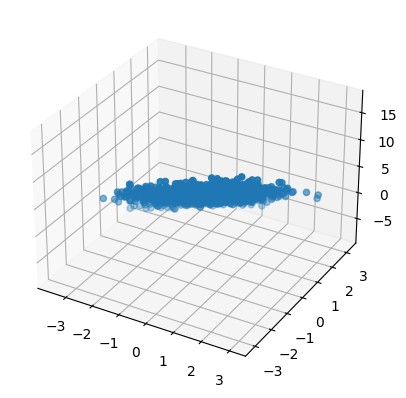

In [31]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data.X[:, 0], data.X[:, 1], data.y)

<Axes: xlabel='$x_i$', ylabel='y'>

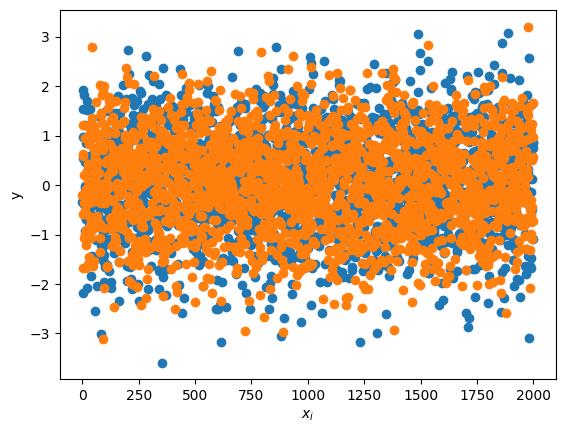

In [24]:
str_lbl_x = "$x_i$"
str_lbl_y = "y"
fig, ax = plt.subplots()
# ax.plot(data.X, data.y, 'o')
ax.plot(data.X, 'o')
ax.set_xlabel(str_lbl_x)
ax.set_ylabel(str_lbl_y)
ax

tensor([-0.3362, -2.1757,  0.9646,  ...,  0.8601, -1.0998,  0.8635])

array([<Axes: >, <Axes: >], dtype=object)

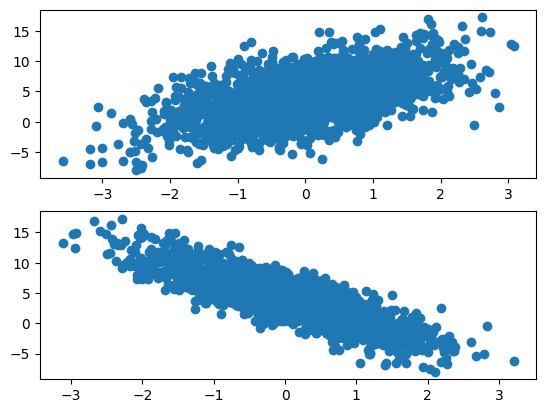

In [29]:
str_lbl_x = "$x_i$"
str_lbl_y = "y"
fig, ax = plt.subplots(2)
ax[0].plot(data.X[:, 0], data.y, 'o')
ax[1].plot(data.X[:, 1], data.y, 'o')
# ax.set_xlabel(str_lbl_x)
# ax.set_ylabel(str_lbl_y)
ax

[**Each row in `features` consists of a vector in $\mathbb{R}^2$ and each row in `labels` is a scalar.**] Let's have a look at the first entry.


In [5]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([ 0.2371, -0.2099]) 
label: tensor([5.3917])


## Reading the Dataset

Training machine learning models often requires multiple passes over a dataset, 
grabbing one minibatch of examples at a time. 
This data is then used to update the model. 
To illustrate how this works, we 
[**implement the `get_dataloader` method,**] 
registering it in the `SyntheticRegressionData` class via `add_to_class` (introduced in :numref:`oo-design-utilities`).
It (**takes a batch size, a matrix of features,
and a vector of labels, and generates minibatches of size `batch_size`.**)
As such, each minibatch consists of a tuple of features and labels. 
Note that we need to be mindful of whether we're in training or validation mode: 
in the former, we will want to read the data in random order, 
whereas for the latter, being able to read data in a pre-defined order 
may be important for debugging purposes.


In [5]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

To build some intuition, let's inspect the first minibatch of
data. Each minibatch of features provides us with both its size and the dimensionality of input features.
Likewise, our minibatch of labels will have a matching shape given by `batch_size`.


In [6]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


While seemingly innocuous, the invocation 
of `iter(data.train_dataloader())` 
illustrates the power of Python's object-oriented design. 
Note that we added a method to the `SyntheticRegressionData` class
*after* creating the `data` object. 
Nonetheless, the object benefits from 
the *ex post facto* addition of functionality to the class.

Throughout the iteration we obtain distinct minibatches
until the entire dataset has been exhausted (try this).
While the iteration implemented above is good for didactic purposes,
it is inefficient in ways that might get us into trouble with real problems.
For example, it requires that we load all the data in memory
and that we perform lots of random memory access.
The built-in iterators implemented in a deep learning framework
are considerably more efficient and they can deal
with sources such as data stored in files, 
data received via a stream, 
and data generated or processed on the fly. 
Next let's try to implement the same method using built-in iterators.

## Concise Implementation of the Data Loader

Rather than writing our own iterator,
we can [**call the existing API in a framework to load data.**]
As before, we need a dataset with features `X` and labels `y`. 
Beyond that, we set `batch_size` in the built-in data loader 
and let it take care of shuffling examples  efficiently.


In [7]:
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

In [8]:
@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

The new data loader behaves just like the previous one, except that it is more efficient and has some added functionality.


In [9]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


For instance, the data loader provided by the framework API 
supports the built-in `__len__` method, 
so we can query its length, 
i.e., the number of batches.


In [10]:
len(data.train_dataloader())

32

## Summary

Data loaders are a convenient way of abstracting out 
the process of loading and manipulating data. 
This way the same machine learning *algorithm* 
is capable of processing many different types and sources of data 
without the need for modification. 
One of the nice things about data loaders 
is that they can be composed. 
For instance, we might be loading images 
and then have a postprocessing filter 
that crops them or modifies them in other ways. 
As such, data loaders can be used 
to describe an entire data processing pipeline. 

As for the model itself, the two-dimensional linear model 
is about the simplest we might encounter. 
It lets us test out the accuracy of regression models 
without worrying about having insufficient amounts of data 
or an underdetermined system of equations. 
We will put this to good use in the next section.  


## Exercises

1. What will happen if the number of examples cannot be divided by the batch size. How would you change this behavior by specifying a different argument by using the framework's API?
1. Suppose that we want to generate a huge dataset, where both the size of the parameter vector `w` and the number of examples `num_examples` are large.
    1. What happens if we cannot hold all data in memory?
    1. How would you shuffle the data if it is held on disk? Your task is to design an *efficient* algorithm that does not require too many random reads or writes. Hint: [pseudorandom permutation generators](https://en.wikipedia.org/wiki/Pseudorandom_permutation) allow you to design a reshuffle without the need to store the permutation table explicitly :cite:`Naor.Reingold.1999`. 
1. Implement a data generator that produces new data on the fly, every time the iterator is called. 
1. How would you design a random data generator that generates *the same* data each time it is called?


[Discussions](https://discuss.d2l.ai/t/6663)
